## Imports

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH083_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH026_04.jpg
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH037_09.jpg
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH068_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH040_04.jpg
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH051_02.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH075_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH008_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH034_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH032_05.jpg
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH048_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH001_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH033_01.png
/kaggle/input/lipodata/data_split_unmapped/val/negative/USLH053_09.png
/kaggl

In [3]:
from torchvision import models, datasets, utils#,transforms
from collections import OrderedDict

from torch import nn, optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch
import os
import math
import os
import matplotlib.pyplot as plt

## Data

In [4]:
IMAGE_SIZE = 300
BATCH_SIZE = 8

#TRAIN_DIR = "../input/lipodata2/data/train"
#VALID_DIR = "../input/lipodata2/data/val"

#TRAIN_DIR = "gdrive/MyDrive/lipo/train"
#VALID_DIR = "gdrive/MyDrive/lipo/val"

TRAIN_DIR = '../input/lipodata/data_split_unmapped/train'
VALID_DIR = '../input/lipodata/data_split_unmapped/val'

train_transforms = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(0, 1.0)),
        A.VerticalFlip(),
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        ToTensorV2(),
        
    ]
)

valid_transforms = A.Compose(
    [
        A.Resize(height = 300, width = 300),
        ToTensorV2(),
        
    ]
)

In [5]:
class LipoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        
        # Create a list of filepaths of images and the respective label
        self.samples = []

        for i in os.listdir(root_dir):
            if i in ["positive", 'negative']:
                folder = os.path.join(root_dir, i)
                target = folder.split("/")[-1]
                for label in os.listdir(folder):
                    filepath = os.path.join(folder, label)
                    self.samples.append((target, filepath))


    def __len__(self):
        # Get the length of the samples 
        return len(self.samples)

    def __getitem__(self, index):
        # Implement logic to get an image and its label using the received index.
        #
        # `image` should be a NumPy array with the shape [height, width, num_channels].
        # If an image contains three color channels, it should use an RGB color scheme.
        #
        # `label` should be an integer in the range [0, model.num_classes - 1] where `model.num_classes`
        # is a value set in the `search.yaml` file.
        
        # get the filepath of the image based on the index and convert it to 
        # color scale and then into a numpy array
        image = np.array(Image.open(self.samples[index][1]).convert("RGB"))

        # maps a label to an integer value
        label_to_int = {"positive": 1, "negative": 0}
        label = label_to_int[self.samples[index][0]]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
            image = image/255

        return image, label

In [6]:
# create a dataset and tranform the images 
dataset = LipoDataset(TRAIN_DIR, transform=train_transforms)
v_dataset = LipoDataset(VALID_DIR, transform=valid_transforms)
# create a dataloader 
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(v_dataset, batch_size=8)

img, label = next(iter(train_loader))
img.shape

torch.Size([8, 3, 300, 300])

## Intialize Model

In [7]:
def weights_init(m, verbose = False):
    """Initialize weights of each layer to make the results more reproducible"""
    if isinstance(m, nn.Conv2d):
        if verbose:
            print("Initializing weights of a Conv2d layer!")
        nn.init.normal_(m.weight, mean=0, std=0.1)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d): 
        if verbose:        
            print("Initializing weights of a batchnorm layer!")
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        if verbose:
            print("Initializing weights of a Linear layer!")
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

In [8]:
def make_model():
    densenet = models.densenet121(pretrained=True)
    new_layers = torch.nn.Sequential(OrderedDict([
        ('new1', torch.nn.Linear(1024, 500)),
        ('relu', torch.nn.ReLU()),
        ('new2', torch.nn.Linear(500, 1))
    ]))
    densenet.classifier = new_layers
    torch.manual_seed(2020)
    densenet.apply(weights_init);
    #densenet.to(device)
    return densenet

In [9]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, patience=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    data_type = torch.float32
    valid_loss = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device,data_type), y.to(device,data_type)
                model.cuda()
            optimizer.zero_grad()
            y_hat = model(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            loss = criterion(y_hat.to(device), y.type(data_type))
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(data_type).sum().item()
        train_accuracy = train_batch_acc / len(train_loader.dataset)
        
        # Validation
        confusion_matrix = torch.zeros(2, 2)
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device,data_type), y.to(device,data_type)
                    model.cuda()
                y_hat = model(X).flatten()
                y_hat_labels = torch.sigmoid(y_hat) > 0.5
                loss = criterion(y_hat.to(device), y.type(data_type))
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(data_type).sum().item()
        valid_accuracy = valid_batch_acc / len(valid_loader.dataset)
        valid_loss.append(valid_batch_loss / len(valid_loader))        
        
        with torch.no_grad():
            for i, (inputs, classes) in enumerate(valid_loader):
                inputs = inputs.to(device)
                classes = classes.to(device)
                outputs = model(inputs).flatten()
                preds = torch.sigmoid(outputs) > 0.5
                for t, p in zip(classes.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1
        recall = confusion_matrix.numpy()[1,1]/(confusion_matrix.numpy()[1,1]+confusion_matrix.numpy()[1,0])
        model.train()
        
        # Early stopping
        if epoch > 0 and valid_loss[-1] > valid_loss[-2]:
            consec_increases += 1
        else:
            consec_increases = 0
        if consec_increases == patience:
            print(f"Stopped early at epoch {epoch + 1} - val loss increased for {consec_increases} consecutive epochs!")
            break
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy:.2f}.",
                  f"Valid Accuracy: {valid_accuracy:.2f}.",
                  f"Valid Recall: {recall:.2f}")
    
    return model

## Positive weight setup

In [10]:
pos_weight2 = torch.ones([1])
pos_weight2[0] = 2
pos_weight2

tensor([2.])

In [11]:
pos_weight3 = torch.ones([1])
pos_weight3[0] = 1.5
pos_weight3

tensor([1.5000])

In [26]:
pos_weight4 = torch.ones([1])
pos_weight4[0] = 152/94
pos_weight4

tensor([1.6170])

In [27]:
pos_weight5 = torch.ones([1])
pos_weight5[0] = 1.2
pos_weight5

tensor([1.2000])

## Use optimized parameters

In [28]:
best_parameters={'lr': np.round(7.456370422609558e-05, 5), 'beta1': np.round(0.9815918038692326, 3)}
best_parameters

{'lr': 7e-05, 'beta1': 0.982}

## Train Model with High Positive Weight

In [29]:
# pos_weight = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight2.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
double_weight = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Epoch 1: Train Accuracy: 0.52. Valid Accuracy: 0.68. Valid Recall: 0.65
Epoch 2: Train Accuracy: 0.55. Valid Accuracy: 0.68. Valid Recall: 0.15
Epoch 3: Train Accuracy: 0.64. Valid Accuracy: 0.66. Valid Recall: 0.85
Epoch 4: Train Accuracy: 0.66. Valid Accuracy: 0.72. Valid Recall: 0.80
Epoch 5: Train Accuracy: 0.61. Valid Accuracy: 0.66. Valid Recall: 0.85
Epoch 6: Train Accuracy: 0.64. Valid Accuracy: 0.72. Valid Recall: 0.85
Epoch 7: Train Accuracy: 0.68. Valid Accuracy: 0.70. Valid Recall: 0.90
Epoch 8: Train Accuracy: 0.63. Valid Accuracy: 0.75. Valid Recall: 0.85
Epoch 9: Train Accuracy: 0.64. Valid Accuracy: 0.68. Valid Recall: 0.85
Epoch 10: Train Accuracy: 0.67. Valid Accuracy: 0.72. Valid Recall: 0.75
Epoch 11: Train Accuracy: 0.68. Valid Accuracy: 0.74. Valid Recall: 0.85
Epoch 12: Train Accuracy: 0.67. Valid Accuracy: 0.74. Valid Recall: 0.55
Epoch 13: Train Accuracy: 0.67. Valid Accuracy: 0.74. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.63. Valid Accuracy: 0.70. Valid 

In [30]:
# pos_weight = 1.617
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight4.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
point6_weight = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.53. Valid Accuracy: 0.68. Valid Recall: 0.65
Epoch 2: Train Accuracy: 0.61. Valid Accuracy: 0.68. Valid Recall: 0.15
Epoch 3: Train Accuracy: 0.67. Valid Accuracy: 0.74. Valid Recall: 0.75
Epoch 4: Train Accuracy: 0.68. Valid Accuracy: 0.70. Valid Recall: 0.75
Epoch 5: Train Accuracy: 0.68. Valid Accuracy: 0.68. Valid Recall: 0.90
Epoch 6: Train Accuracy: 0.69. Valid Accuracy: 0.75. Valid Recall: 0.75
Epoch 7: Train Accuracy: 0.69. Valid Accuracy: 0.72. Valid Recall: 0.60
Epoch 8: Train Accuracy: 0.71. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 9: Train Accuracy: 0.65. Valid Accuracy: 0.70. Valid Recall: 0.90
Epoch 10: Train Accuracy: 0.67. Valid Accuracy: 0.77. Valid Recall: 0.60
Epoch 11: Train Accuracy: 0.71. Valid Accuracy: 0.79. Valid Recall: 0.75
Epoch 12: Train Accuracy: 0.70. Valid Accuracy: 0.70. Valid Recall: 0.70
Epoch 13: Train Accuracy: 0.71. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.66. Valid Accuracy: 0.75. Valid 

In [31]:
# pos_weight = 1.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight3.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
half_weight = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.54. Valid Accuracy: 0.49. Valid Recall: 1.00
Epoch 2: Train Accuracy: 0.58. Valid Accuracy: 0.68. Valid Recall: 0.25
Epoch 3: Train Accuracy: 0.64. Valid Accuracy: 0.72. Valid Recall: 0.45
Epoch 4: Train Accuracy: 0.64. Valid Accuracy: 0.77. Valid Recall: 0.55
Epoch 5: Train Accuracy: 0.63. Valid Accuracy: 0.66. Valid Recall: 0.85
Epoch 6: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.70
Epoch 7: Train Accuracy: 0.66. Valid Accuracy: 0.74. Valid Recall: 0.85
Epoch 8: Train Accuracy: 0.65. Valid Accuracy: 0.70. Valid Recall: 0.90
Epoch 9: Train Accuracy: 0.67. Valid Accuracy: 0.79. Valid Recall: 0.80
Epoch 10: Train Accuracy: 0.67. Valid Accuracy: 0.75. Valid Recall: 0.60
Epoch 11: Train Accuracy: 0.69. Valid Accuracy: 0.74. Valid Recall: 0.80
Epoch 12: Train Accuracy: 0.70. Valid Accuracy: 0.74. Valid Recall: 0.80
Epoch 13: Train Accuracy: 0.66. Valid Accuracy: 0.75. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.64. Valid Accuracy: 0.70. Valid 

In [32]:
# pos_weight = 1.2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight5.to(device))
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
point2_weight = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.60. Valid Accuracy: 0.58. Valid Recall: 0.00
Epoch 2: Train Accuracy: 0.64. Valid Accuracy: 0.64. Valid Recall: 0.05
Epoch 3: Train Accuracy: 0.67. Valid Accuracy: 0.75. Valid Recall: 0.45
Epoch 4: Train Accuracy: 0.64. Valid Accuracy: 0.74. Valid Recall: 0.45
Epoch 5: Train Accuracy: 0.63. Valid Accuracy: 0.77. Valid Recall: 0.85
Epoch 6: Train Accuracy: 0.65. Valid Accuracy: 0.75. Valid Recall: 0.50
Epoch 7: Train Accuracy: 0.64. Valid Accuracy: 0.77. Valid Recall: 0.70
Epoch 8: Train Accuracy: 0.63. Valid Accuracy: 0.75. Valid Recall: 0.80
Epoch 9: Train Accuracy: 0.63. Valid Accuracy: 0.70. Valid Recall: 0.90
Epoch 10: Train Accuracy: 0.67. Valid Accuracy: 0.85. Valid Recall: 0.75
Epoch 11: Train Accuracy: 0.70. Valid Accuracy: 0.83. Valid Recall: 0.75
Epoch 12: Train Accuracy: 0.73. Valid Accuracy: 0.77. Valid Recall: 0.65
Epoch 13: Train Accuracy: 0.68. Valid Accuracy: 0.70. Valid Recall: 0.85
Epoch 14: Train Accuracy: 0.69. Valid Accuracy: 0.81. Valid 

## Train the Model with Normal Weight 

In [33]:
# pos_weight = None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
betas = (best_parameters["beta1"], 0.999)
model = make_model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr = best_parameters["lr"],
                                betas = betas)
normal_weight = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=45
               )

Epoch 1: Train Accuracy: 0.59. Valid Accuracy: 0.70. Valid Recall: 0.40
Epoch 2: Train Accuracy: 0.60. Valid Accuracy: 0.62. Valid Recall: 0.00
Epoch 3: Train Accuracy: 0.65. Valid Accuracy: 0.77. Valid Recall: 0.70
Epoch 4: Train Accuracy: 0.66. Valid Accuracy: 0.74. Valid Recall: 0.35
Epoch 5: Train Accuracy: 0.68. Valid Accuracy: 0.83. Valid Recall: 0.75
Epoch 6: Train Accuracy: 0.63. Valid Accuracy: 0.85. Valid Recall: 0.75
Epoch 7: Train Accuracy: 0.68. Valid Accuracy: 0.75. Valid Recall: 0.55
Epoch 8: Train Accuracy: 0.66. Valid Accuracy: 0.85. Valid Recall: 0.75
Epoch 9: Train Accuracy: 0.67. Valid Accuracy: 0.77. Valid Recall: 0.85
Epoch 10: Train Accuracy: 0.69. Valid Accuracy: 0.83. Valid Recall: 0.60
Epoch 11: Train Accuracy: 0.69. Valid Accuracy: 0.81. Valid Recall: 0.70
Epoch 12: Train Accuracy: 0.72. Valid Accuracy: 0.81. Valid Recall: 0.65
Epoch 13: Train Accuracy: 0.67. Valid Accuracy: 0.85. Valid Recall: 0.80
Epoch 14: Train Accuracy: 0.70. Valid Accuracy: 0.83. Valid 

## Test on Holdout sample

In [34]:
TEST_DIR = '../input/lipodata/data_split_unmapped/test'
test_dataset = LipoDataset(TEST_DIR, transform=valid_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [61]:
def pytorch_confusion_matrix(cnn, data_loader):
    """return confusion matrix on a holdout sample for a pytorch cnn model(binary classification)"""
    confusion_matrix = torch.zeros(2, 2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    cnn.eval()
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = cnn(inputs).flatten()
            preds = torch.sigmoid(outputs) > 0.5
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    cm = pd.DataFrame(confusion_matrix.numpy(), columns = ['predict negative','predict positive'], index = ['actual negative', 'actual positive'])
    return cm

In [62]:
def confusion_matrix_eval(cnn, data_loader):
    """retrieves false positives and false negatives for further investigation"""
    fp = []
    fn = []
    cnn.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            print(i)
            inputs = inputs.to(device, torch.float32)
            print(inputs.shape)
            classes = classes.to(device, torch.float32)
            outputs = cnn(inputs).flatten()
            preds = torch.sigmoid(outputs) > 0.5
            j = 0 
            for t, p in zip(classes.view(-1), preds.view(-1)):
                print('ta', float(t.cpu().numpy()), 'pa', float(p.long().cpu().numpy()))
                if [float(t.cpu().numpy()), float(p.long().cpu().numpy())] == [0.0, 1.0]:
                    fp.append(data_loader.dataset.samples[(i*data_loader.batch_size+j)][1])
                elif [float(t.cpu().numpy()), float(p.long().cpu().numpy())] == [1.0, 0.0]:
                    fn.append(data_loader.dataset.samples[(i*data_loader.batch_size+j)][1])
                j += 1
        return {'false_positives': fp, 'false_negatives': fn}

In [63]:
def get_test_accuracy(cnn, data_loader):
    """return accuracy on a holdout sample for a pytorch cnn model"""
    test_batch_acc = 0
    cnn.eval()
    with torch.no_grad():
        for X, y in data_loader:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            y_hat = cnn(X).flatten()
            y_hat_labels = torch.sigmoid(y_hat) > 0.5
            test_batch_acc += (y_hat_labels == y).type(torch.float32).sum().item()
    test_accuracy = test_batch_acc / len(data_loader.dataset)
    #print(f"Test accuracy is {test_accuracy*100:.2f}%.")
    return test_accuracy

In [65]:
def recall_calculation(confusion_matrix):
    """return recall of holdout sample from a confusion matrix"""
    test_recall = confusion_matrix.iloc[1,1]/(confusion_matrix.iloc[1,1]+confusion_matrix.iloc[1,0])
    #print(f"Test recall is {test_recall*100:.2f}%.")
    return test_recall

Below, we can see that by doubling the weight for the positive examples, the model predicts no false negatives and rather we have many false positives (31). 

In [68]:
def final_evaluator(cnn, data_loader):
    acc = get_test_accuracy(cnn, data_loader)
    print(f"Test accuracy is {acc*100:.2f}%.")
    matrix = pytorch_confusion_matrix(cnn, data_loader)
    recall = recall_calculation(matrix)
    print(f"Test recall is {recall*100:.2f}%.")
    return matrix

In [69]:
# pos_weight = 2
final_evaluator(double_weight, test_loader)

Test accuracy is 72.22%.
Test recall is 90.48%.


predict negative  predict positive
actual negative              20.0              13.0
actual positive               2.0              19.0

In [70]:
# pos_weight = 1.62
final_evaluator(point6_weight, test_loader)

Test accuracy is 79.63%.
Test recall is 71.43%.


predict negative  predict positive
actual negative              28.0               5.0
actual positive               6.0              15.0

In [71]:
# pos_weight = 1.5
final_evaluator(half_weight, test_loader)

Test accuracy is 81.48%.
Test recall is 71.43%.


predict negative  predict positive
actual negative              29.0               4.0
actual positive               6.0              15.0

In [72]:
# pos_weight = 1.2
final_evaluator(point2_weight, test_loader)

Test accuracy is 75.93%.
Test recall is 76.19%.


predict negative  predict positive
actual negative              25.0               8.0
actual positive               5.0              16.0

In [74]:
 final_evaluator(normal_weight, test_loader)

Test accuracy is 79.63%.
Test recall is 61.90%.


predict negative  predict positive
actual negative              30.0               3.0
actual positive               8.0              13.0

In [78]:
list_of_weights = [double_weight, point6_weight, half_weight, point2_weight, normal_weight]

recall_list = [recall_calculation(pytorch_confusion_matrix(i, test_loader)) for i in list_of_weights]

acc_list = [get_test_accuracy(i, test_loader) for i in list_of_weights]

    

summary_df = pd.DataFrame({'pos_weight': ["None", pos_weight2, pos_weight3, pos_weight4, pos_weight5], 
            'accuracy': acc_list,
            'recall': recall_list
             })

summary_df

pos_weight  accuracy    recall
0              None  0.722222  0.904762
1      [tensor(2.)]  0.796296  0.714286
2  [tensor(1.5000)]  0.814815  0.714286
3  [tensor(1.6170)]  0.759259  0.761905
4  [tensor(1.2000)]  0.796296  0.619048

## Visualize the False Positives

In [82]:
# get the file images that the model predicting that are false positives
false_positives_dbl = confusion_matrix_eval(double_weight, test_loader)["false_positives"]
false_positives_dbl

0
torch.Size([8, 3, 300, 300])
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
1
torch.Size([8, 3, 300, 300])
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
2
torch.Size([8, 3, 300, 300])
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
3
torch.Size([8, 3, 300, 300])
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 0.0
ta 0.0 pa 0.0
ta 0.0 pa 1.0
ta 0.0 pa 1.0
4
torch.Size([8, 3, 300, 300])
ta 0.0 pa 0.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
5
torch.Size([8, 3, 300, 300])
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
6
torch.Size([6, 3, 300, 300])
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 1.0
ta 1.0 pa 0.0
ta 1.0 pa 1.0
ta 1.0 pa 0.0


['../input/lipodata/data_split_unmapped/test/negative/USLH040_06.jpg',
 '../input/lipodata/data_split_unmapped/test/negative/USLH026_01.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH021_15.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH067_02.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH088_01.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH033_06.jpg',
 '../input/lipodata/data_split_unmapped/test/negative/USLH056_02.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH067_01.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH021_01.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH097_02.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH069_01.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH060_03.png',
 '../input/lipodata/data_split_unmapped/test/negative/USLH038_10.jpg']

In [83]:
# source - https://stackoverflow.com/questions/20038648/writting-a-file-with-multiple-images-in-a-grid
# visualize
def display_grid(images_list):
    
    images_count = len(images_list)
    print('False Positive Images count: ', images_count)
    
    # Calculate the grid size:
    grid_size = math.ceil(math.sqrt(images_count))
    
    # Create plt plot
    fig, axes = plt.subplots(grid_size, grid_size, 
                         figsize=(40, 40))
    
    for i in range(images_count):
        x_position = i % grid_size
        y_position = i // grid_size
        
        plt_image = plt.imread(images_list[i])
        axes[x_position, y_position].imshow(plt_image)
        
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)

False Positive Images count:  13


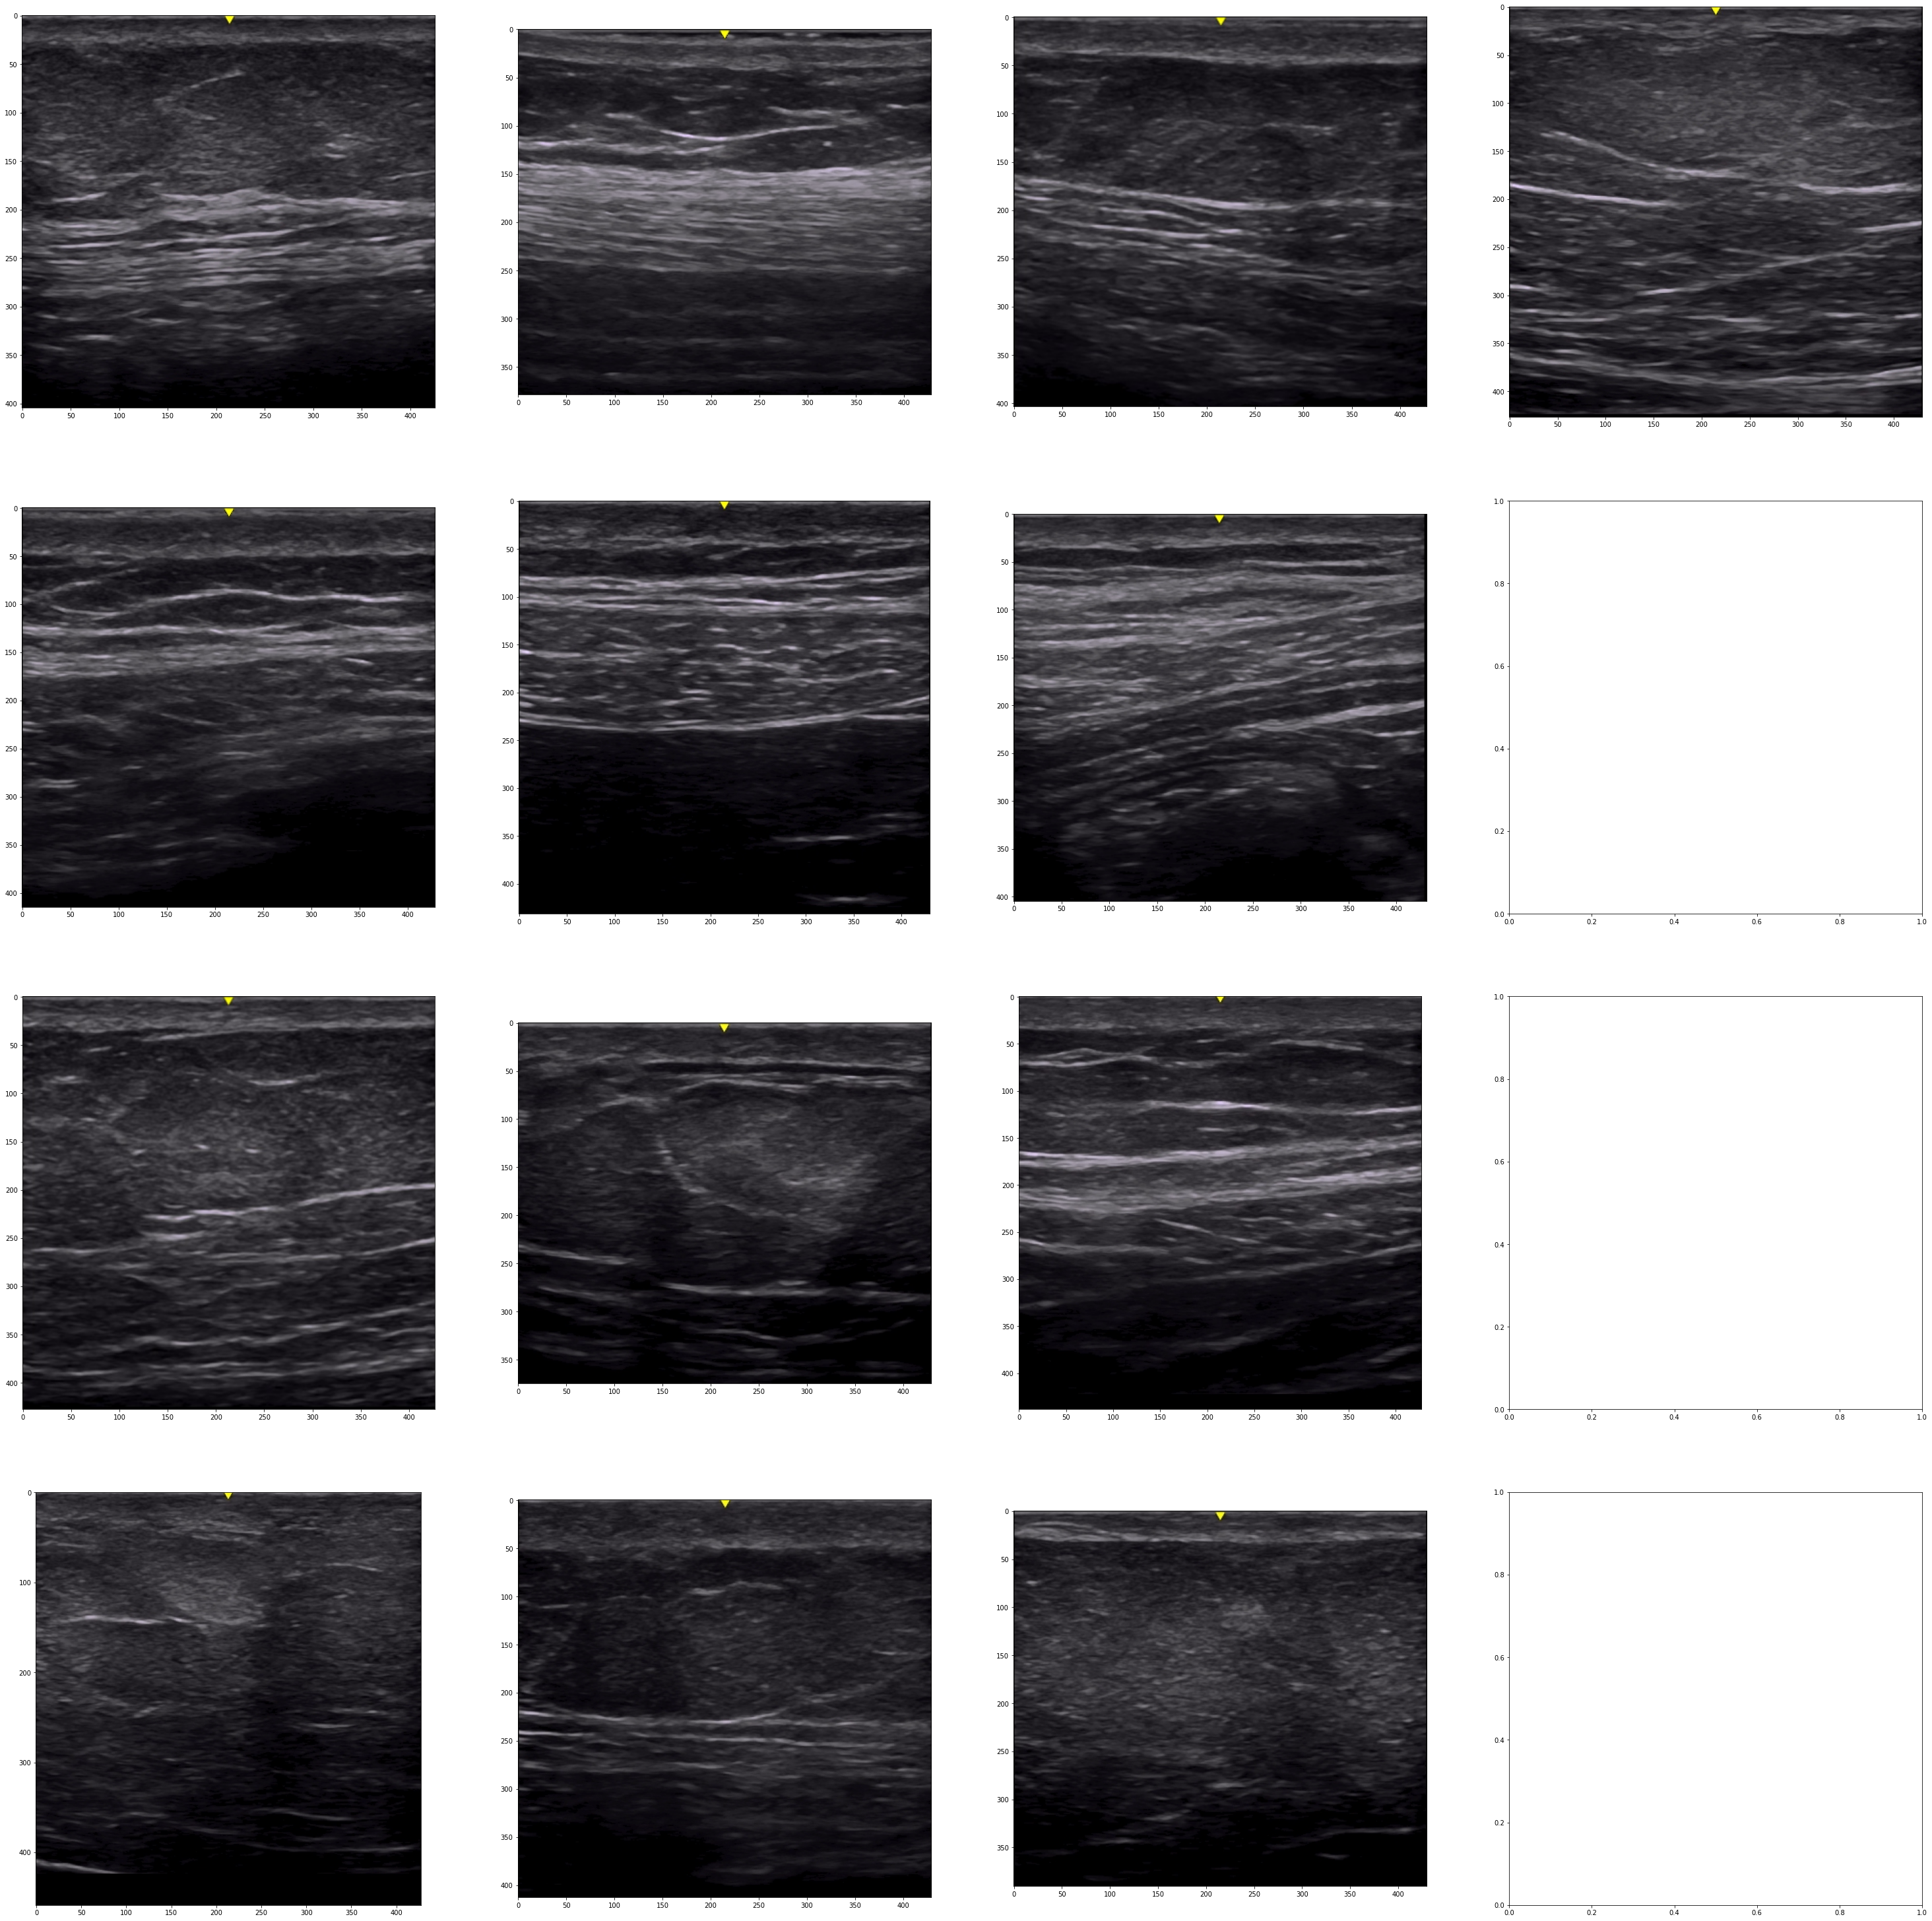

In [85]:
display_grid(false_positives_dbl)